### Packages

In [79]:
# Data wrangling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

# Added
import statsmodels.formula.api as smf

### Functions

In [80]:
# Define function that print the minimum and maximum values of a defines variable in the data frame
def get_min_and_max(df, variable_name, no_min, no_max):
    array = df[variable_name].fillna(0).unique()
    sorted_array = np.sort(array)
    
    min_values = sorted_array[:no_min]
    max_values = sorted_array[-no_max:]
    
    print(f"{no_min} minimum values of '{variable_name}':")
    print(min_values)
    print('\n')
    print(f"{no_max} maximum values of '{variable_name}':")
    print(max_values)

In [81]:
def plot_distribution(data, column_name):
    # Create a figure with two vertically aligned subplots
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

    # Plotting the histogram
    sns.histplot(data[column_name], kde=True, ax=axes[0])
    axes[0].set_title(f"Distribution of {column_name}")
    axes[0].set_xlabel(f"{column_name}")
    axes[0].set_ylabel("Frequency")

    # Plotting the boxplot
    sns.boxplot(x=data[column_name], ax=axes[1])
    axes[1].set_title(f"Distribution of {column_name}")
    axes[1].set_xlabel(f"{column_name}")

    # Adjust layout
    plt.tight_layout()
    plt.show()


# Data wrangling and exploration

We begin by loading the two data sets and looking at the different attributes. We decide to add two columns **Movie release year** and **Actor birth year**.

In [82]:
# Load datasets
data_folder = './data_cleaned/'
movie_metadata = pd.read_csv(data_folder + 'movie_cleaned.csv', lineterminator='\n')
character_metadata = pd.read_csv(data_folder + 'character_cleaned.csv')

/var/folders/zp/zj6kbf7d5mv37j0rsdb53g200000gn/T/ipykernel_6259/132682489.py:3: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_metadata = pd.read_csv(data_folder + 'movie_cleaned.csv', lineterminator='\n')


# Start Emma

**Change column names**

In [83]:
# Replace spaces with underscores in column names
movie_metadata.columns = movie_metadata.columns.str.replace(' ', '_')
character_metadata.columns = character_metadata.columns.str.replace(' ', '_')

**Filter so that only movies with revenue are included**


In [84]:
movie_metadata = movie_metadata[movie_metadata['Movie_box_office_revenue'].notna()]

In [85]:
movie_metadata.shape

(10018, 26)

**Look at attributes and see where we have missing data**

In [86]:
movie_metadata.isna().sum()

Unnamed:_0                         0
Wikipedia_Movie_ID                 0
Freebase_Movie_ID                  0
Movie_name                         0
Movie_release_date                73
Movie_runtime                    308
Movie_languages                    0
Movie_countries                    0
Movie_genres                       0
TMDB_id                          123
TMDB_original_language           123
TMDB_original_title              123
TMDB_overview                    143
TMDB_popularity                  123
TMDB_release_date                152
TMDB_title                       123
TMDB_vote_average                123
TMDB_vote_count                  123
TMDB_runtime                    4688
TMDB_budget                     4688
TMDB_IMDB_id                    4727
TMDB_genres                     4718
Movie_box_office_revenue           0
Movie_release_year                74
log_Movie_box_office_revenue       0
log_Movie_release_year            74
dtype: int64

We are missing vote average data from 123 movies. Since we want to build a linear regression model on this column we further filter the data to only include movies where there is an vote averag. You can also see that a lot of budget data is missing. As we will see later we do not think we can use this data and we will therefore not filter for this value. 

In [87]:
movie_metadata = movie_metadata[movie_metadata['TMDB_vote_average'].notna()]

In [88]:
movie_metadata.shape

(9895, 26)

**TMDB vote count**

We will now look at the TMDB vote count column

In [89]:
get_min_and_max(df=movie_metadata, variable_name='TMDB_vote_count', no_min=10, no_max=10)

10 minimum values of 'TMDB_vote_count':
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


10 maximum values of 'TMDB_vote_count':
[24843. 24994. 25554. 25601. 26088. 27446. 29290. 29943. 30843. 34697.]


In [90]:
movie_metadata['TMDB_vote_count'].describe()

count     9895.000000
mean      1015.483679
std       2401.807889
min          0.000000
25%         40.000000
50%        192.000000
75%        865.500000
max      34697.000000
Name: TMDB_vote_count, dtype: float64

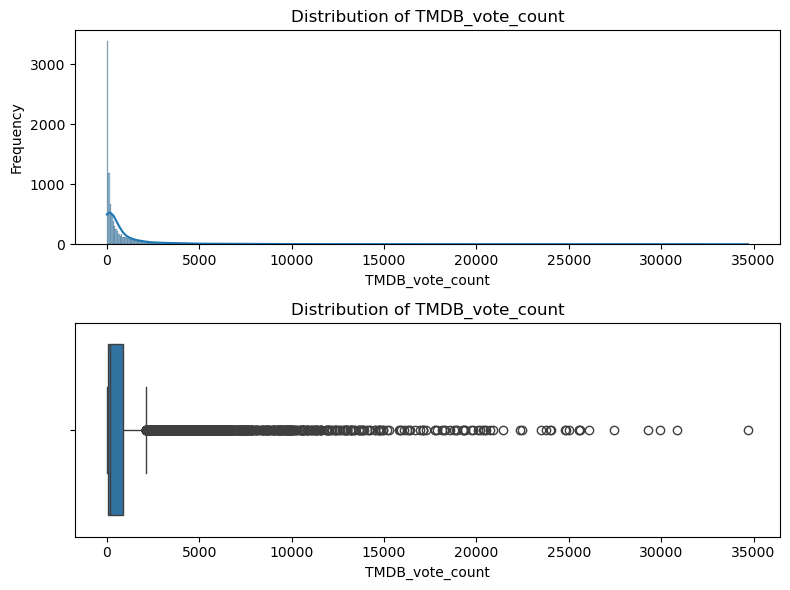

In [91]:
# Example usage
plot_distribution(movie_metadata, 'TMDB_vote_count')


We see that a lot of movies have 0 vote counts and the data is heavily tailed. It does not make sense to include data for movies where the vote count is 0. We can first try get an overview over how much data we would loose if we filter out only the movies with 0 votes. Then we look at other cut-off values to get an overview. 

In [92]:
# Create a copy of the original DataFrame for comparison
original_df = movie_metadata.copy()

# Define a list of cutoff values to test
cutoff_values = [0, 1, 2, 4, 6, 8, 10, 20, 50]  # Add more values as needed

# Create a dictionary to store results
data_loss_results = {'Cutoff Value': [], 'Data Loss Percentage': [], 'Data Length': []}

# Iterate through cutoff values
for cutoff in cutoff_values:
    # Create a condition based on the cutoff
    condition = (original_df['TMDB_vote_count'] >= cutoff)
    
    # Apply the condition to filter the DataFrame
    filtered_df = original_df[condition]
    
    # Calculate the percentage of data loss
    data_loss_percentage = ((len(original_df) - len(filtered_df)) / len(original_df)) * 100
    data_length = len(filtered_df)

    # Append the results to the dictionary
    data_loss_results['Cutoff Value'].append(cutoff)
    data_loss_results['Data Loss Percentage'].append(data_loss_percentage)
    data_loss_results['Data Length'].append(data_length)

# Convert the results dictionary to a DataFrame for easier visualization
results_df = pd.DataFrame(data_loss_results)

# Print or visualize the results
results_df


,Cutoff Value,Data Loss Percentage,Data Length
0,0,0.000000,9895
1,1,1.616978,9735
2,2,2.486104,9649
3,4,4.325417,9467
4,6,6.083881,9293
5,8,7.983830,9105
6,10,9.530066,8952
7,20,15.957554,8316
8,50,27.892875,7135


We decide to remove movies with less than 4 votes.

In [93]:
condition = (movie_metadata['TMDB_vote_count'] >= 4)
movie_metadata = movie_metadata[condition]

We create a new column with a log transformation of the column. 

In [94]:
movie_metadata['log_TMDB_vote_count']= np.log(movie_metadata['TMDB_vote_count'])

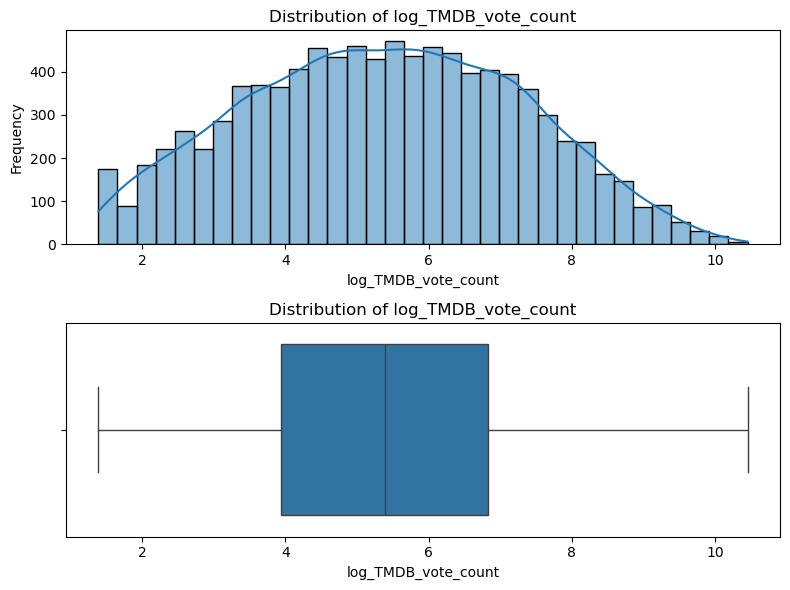

In [95]:
# Example usage
plot_distribution(movie_metadata, 'log_TMDB_vote_count')

**Runtime**

We now look at the runtime of the movie. We both have runtime from the original dataset and from the TMDB dataset. We can see that a lot of data is missing in TMDB runtime. Also data is missing in the movie metadata 

In [96]:
movie_metadata['TMDB_runtime'].isna().sum()

4363

In [97]:
movie_metadata['Movie_runtime'].isna().sum()

247

We want to populate the Movie runtime column with data from the the TMDB runtime column

In [98]:
# Fill missing values in 'Movie_runtime' with values from 'TMDB_runtime'
movie_metadata['Movie_runtime'] = movie_metadata['Movie_runtime'].fillna(movie_metadata['TMDB_runtime'])
movie_metadata['Movie_runtime'].isna().sum()

44

We now want to look at whether the `Movie runtime`` data should be filtered

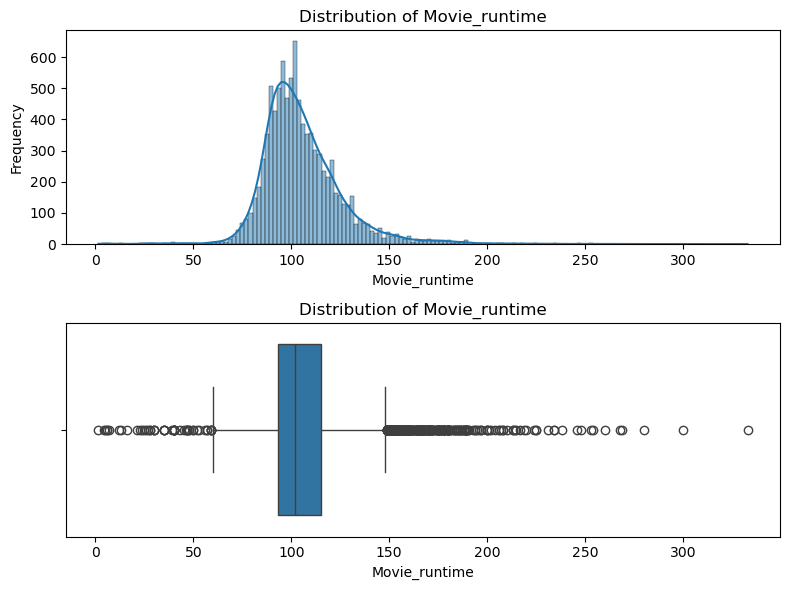

In [99]:
# Example usage
plot_distribution(movie_metadata, 'Movie_runtime')

We decide to only filter movies with runtime of 0

In [100]:
get_min_and_max(df=movie_metadata, variable_name='Movie_runtime', no_min=5, no_max=5)

5 minimum values of 'Movie_runtime':
[0.  1.5 4.5 5.  6. ]


5 maximum values of 'Movie_runtime':
[268. 269. 280. 300. 333.]


In [101]:
condition = (movie_metadata['Movie_runtime'] > 0)
movie_metadata = movie_metadata[condition]

In [102]:
movie_metadata.shape

(9423, 27)

**Revenue/budget**

Text(0.5, 1.0, 'Distribution of TMDB_budget')

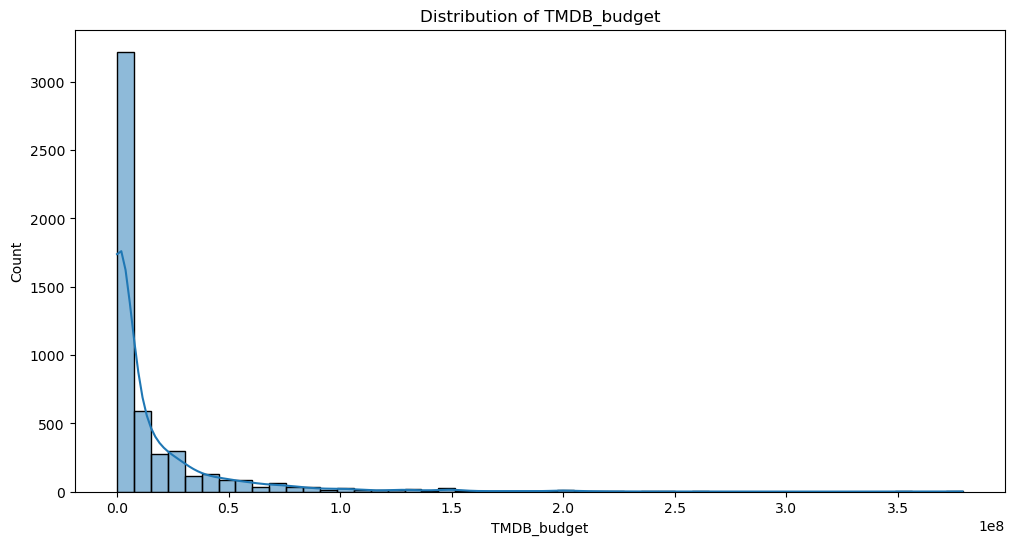

In [103]:
plt.figure(figsize=(12, 6))
sns.histplot(movie_metadata['TMDB_budget'],kde=True, bins=50)
plt.title("Distribution of TMDB_budget")

In [104]:
get_min_and_max(df=movie_metadata, variable_name='TMDB_budget', no_min=10, no_max=10)

10 minimum values of 'TMDB_budget':
[  0.   1.   5.   6.   8.  12.  35.  90. 107. 120.]


10 maximum values of 'TMDB_budget':
[2.09e+08 2.10e+08 2.15e+08 2.20e+08 2.25e+08 2.37e+08 2.50e+08 2.58e+08
 3.56e+08 3.79e+08]


Count how many movies have a budget of 0. Since so many movies have a budget of 0 we should probably exclude this data

In [105]:
movie_metadata[movie_metadata['TMDB_budget'] == 0]['TMDB_budget'].count()

2076

In [106]:
#movie_metadata = movie_metadata[movie_metadata['TMDB_budget']>0]

/Users/emmaceleste/miniconda3/envs/ada/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


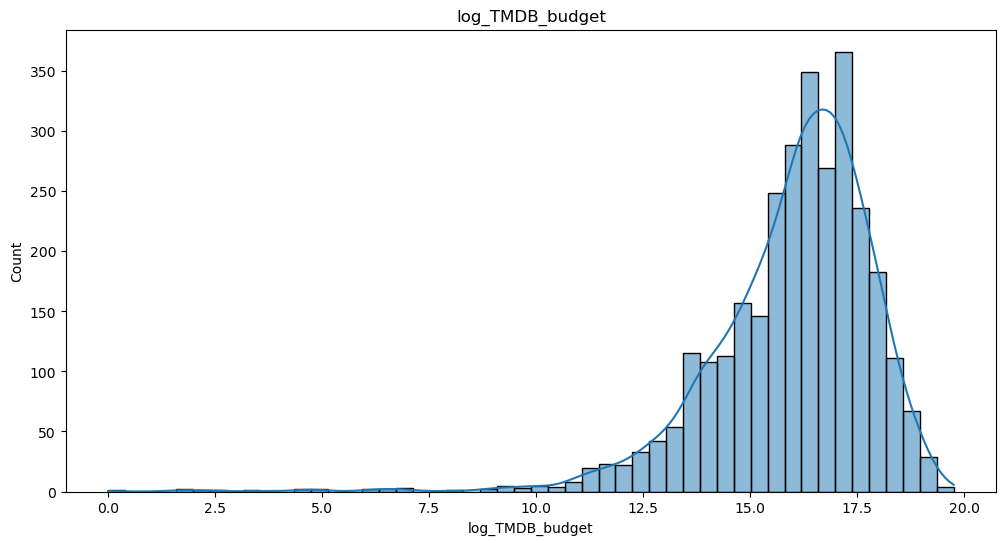

In [107]:
movie_metadata['TMDB_rev_min_budget'] = movie_metadata['Movie_box_office_revenue'] - movie_metadata['TMDB_budget']
movie_metadata['log_TMDB_budget'] = np.log(movie_metadata['TMDB_budget'])

plt.figure(figsize=(12, 6))
sns.histplot(movie_metadata['log_TMDB_budget'], kde=True, bins=50)
plt.title("log_TMDB_budget")
plt.show() 

In [108]:
movie_metadata['log_TMDB_budget']

0        17.147715
7        14.508658
13       16.012735
17       15.607270
21            -inf
           ...    
81694          NaN
81695          NaN
81720          NaN
81725          NaN
81726          NaN
Name: log_TMDB_budget, Length: 9423, dtype: float64

**Male actor percentage**

We filter the character metadata so that only movies in movie metadata are included

In [109]:
# Get a list of unique movie IDs from movie_metadata
unique_movie_ids = movie_metadata['Wikipedia_Movie_ID'].unique()

# Filter character_metadata based on the unique movie IDs
character_metadata = character_metadata[character_metadata['Wikipedia_Movie_ID'].isin(unique_movie_ids)]
character_metadata.isna().mean()

Unnamed:_0                    0.000000
Wikipedia_Movie_ID            0.000000
Freebase_Movie_ID             0.000000
Movie_release_date            0.000000
Character_name                0.364582
Actor_DOB                     0.173609
Actor_gender                  0.068915
Actor_height                  0.478372
Actor_ethnicity               0.685927
Actor_name                    0.002130
Actor_age_at_movie_release    0.213855
Freebase_character_map        0.000000
Freebase_character_ID         0.364538
Freebase_actor_ID             0.001636
Movie_release_year            0.000000
Actor_birth_year              0.173663
log_Movie_release_year        0.000000
dtype: float64

In [110]:
#Group character_metadata by 'Wikipedia Movie ID' and calculate the percentage of male/female actors in each movie
male_percentage_per_movie = character_metadata.groupby('Wikipedia_Movie_ID')['Actor_gender'].apply(lambda x: (x == 'M').sum() / len(x) * 100).reset_index()
male_percentage_per_movie.columns = ['Wikipedia_Movie_ID', 'Male_actor_percentage']


# Merge the m dataframe with movie_metadata on 'Wikipedia Movie ID'
movie_metadata = pd.merge(movie_metadata, male_percentage_per_movie, on='Wikipedia_Movie_ID', how='left')


**Average age of actors**

In [111]:
# Group character_metadata by 'Wikipedia Movie ID' and calculate the average birth year of actors in each movie
average_actor_age_per_movie = character_metadata.groupby('Wikipedia_Movie_ID')['Actor_age_at_movie_release'].mean().reset_index()
average_actor_age_per_movie.columns = ['Wikipedia_Movie_ID', 'Mean_actor_age_at_movie_release']

# Merge the dataframe with movie_metadata on 'Wikipedia Movie ID'
movie_metadata = pd.merge(movie_metadata, average_actor_age_per_movie, on='Wikipedia_Movie_ID', how='left')
